In [14]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
%matplotlib inline

In [2]:
train_dataset = datasets.CIFAR10(root = 'data', train = True,  transform = T.ToTensor(), download = True)
test_dataset  = datasets.CIFAR10(root = 'data', train = False, transform = T.ToTensor())

Files already downloaded and verified


In [3]:
msd_hist = torch.load('msd_hist.pt').numpy()

msd_means = np.mean(msd_hist, axis=0)

In [4]:
# Normalize
msd_means = (msd_means - min(msd_means))/(np.max(msd_means) - np.min(msd_means))

## Calculate known supervised metrics

In [5]:
import wandb

wandb.login()
run = wandb.init(project='Hard and Rare')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: natifick. Use `wandb login --relogin` to force relogin


In [21]:
class MyDataset(Dataset):
    """
    The only modification - returns not only X and Y, but also index
    To track the difficulty
    """
    def __init__(self, values, targets, transform):
        self.transform = transform
        self.values = values
        self.targets = targets

    def __len__(self):
        return len(self.values)

    def __getitem__(self, idx):
        return idx, self.transform(self.values[idx]), self.targets[idx]


def train_track(model, first_set, second_set, optim, loss, 
                n_epochs, device, split="first"):
    """
    Utility-function to train the model while logging all metrics
    """
    model = model.to(device)
    loader_1 = DataLoader(first_set, batch_size=256, shuffle=True)
    loader_2 = DataLoader(second_set, batch_size=256, shuffle=True)
    # Yes, I didn't find how to do it good enough
    if split == "first":
        running_accuracy = np.zeros([len(first_set.targets), n_epochs])
        running_value = np.zeros([len(first_set.targets), n_epochs])
    else:
        running_accuracy = np.zeros([len(second_set.targets), n_epochs])
        running_value = np.zeros([len(second_set.targets), n_epochs])
    for ep in tqdm(range(n_epochs)):
        total_accuracy = 0
        total_loss = 0
        for vals, X_batch, y_batch in loader_1:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optim.zero_grad()
            out = model(X_batch)
            l = loss(out, y_batch)
            l.backward()
            optim.step()
            total_loss += l.item()
            if split == "second":
                continue
            for pos, vec, y in zip(vals.numpy(), out, y_batch):
                running_accuracy[int(pos.item()), ep] = (torch.argmax(vec)==y).item()
                running_value[int(pos.item()), ep] = vec[y].item()
            total_accuracy += torch.sum(torch.argmax(out, dim=1) == y_batch).item()
        wandb.log({"loss": total_loss,
                   "accuracy": total_accuracy / len(first_set)})
        if split == "first":
            continue
        with torch.no_grad():
            for vals, X_batch, y_batch in loader_2:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                model.eval()
                out = model(X_batch)
                for pos, vec, y in zip(vals.numpy(), out, y_batch):
                    running_accuracy[int(pos.item()), ep] = (torch.argmax(vec)==y).item()
                    running_value[int(pos.item()), ep] = vec[y].item()
                total_accuracy += torch.sum(torch.argmax(out, dim=1) == y_batch).item()
            wandb.log({"accuracy": total_accuracy / len(first_set)})
    return running_accuracy, running_value


def calculate_metrics(model, first_dataset, second_dataset, optim, loss, 
                   n_epochs=100, device=torch.device("cuda:0")):
    """
    This one is separate from other algorithms, because it takes two datasets
    :param model - your model to test
    :param first_dataset - first dataset, to train the model
    :param second_dataset - another dataset (still labeled!) to re-train the model
    
    :outputs: SSFT_metric, cartography, ChangeTimes
    :SSFT_metric - two arrays - remember time and forget time
    :cartography - array with predicted values for correct label on each epoch
    :ChangeTimes - array with the number of times that the correct label was changed to incorrect
    """
    print(first_dataset.transform)
    first_dataset = MyDataset(first_dataset.data, first_dataset.targets, first_dataset.transform)
    second_dataset = MyDataset(second_dataset.data, second_dataset.targets, second_dataset.transform)
    
    first_split, cartography = train_track(model, first_dataset, second_dataset, 
                                           optim, loss, n_epochs, device)
    # Firt Split Learn Time
    # Yes, I named it myself, since the paper doesn't
    fsrt = -np.ones(len(first_dataset.targets))
    # Number of changes of correct label from right to wrong
    changes = np.zeros(len(first_dataset.targets))
    for i in range(n_epochs-1, 1, -1):
        fsrt[(fsrt == -1) & (first_split[:, i]-first_split[:, i-1]==1)] = i
        changes[first_split[:, i]-first_split[:, i-1] == -1] += 1
    
    second_split, _ = train_track(model, second_dataset, first_dataset, optim, 
                                  loss, n_epochs, device, split="second")
    # Second split remember time
    ssft = -np.ones(len(first_dataset.targets))
    for i in range(n_epochs-1, 1, -1):
        ssft[(ssft == -1) & (second_split[:, i]-second_split[:, i-1]==-1)] = i
        changes[second_split[:, i]-second_split[:, i-1] == -1] += 1

    return (fsrt, ssft), cartography, changes

## Test the metric calculation function

In [11]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*32*32, 1024),
    nn.ReLU(),
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=1)
)
optim = torch.optim.Adam(model.parameters(), lr=3e-4)

In [22]:
import torchvision

backbone = torchvision.models.resnet18().to(device)

In [62]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transform_clf = T.Compose([
    T.Resize((32, 32)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.Normalize(mean=MEAN, std=STD),
])

ds_train = datasets.CIFAR10(root='../data', transform=train_transform_clf, download=True)
ds_test = datasets.CIFAR10(root='../data', train=False, transform=train_transform_clf, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [63]:
optim = torch.optim.Adam(backbone.parameters(), lr=3e-4)
loss = nn.CrossEntropyLoss()

(fsrt, ssft), cartography, changes = calculate_metrics(backbone, ds_train, ds_test, optim, loss, n_epochs=50)

Compose(
      Resize(size=[32, 32], interpolation=InterpolationMode.BILINEAR, antialias=True)
      ToImage()
      ToDtype(scale=True)
      RandomHorizontalFlip(p=0.5)
      RandomRotation(degrees=[-10.0, 10.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
      ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2))
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [47:31<00:00, 57.04s/it]


### Show cartography

In [64]:
cartography.shape

(50000, 50)

In [65]:
x =  np.std(cartography, axis=1)
y = np.mean(cartography, axis=1)

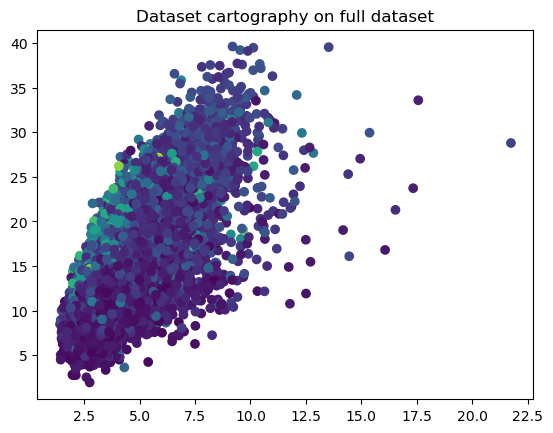

In [66]:
plt.title("Dataset cartography on full dataset")
plt.scatter(x, y, c=msd_means)
plt.show()

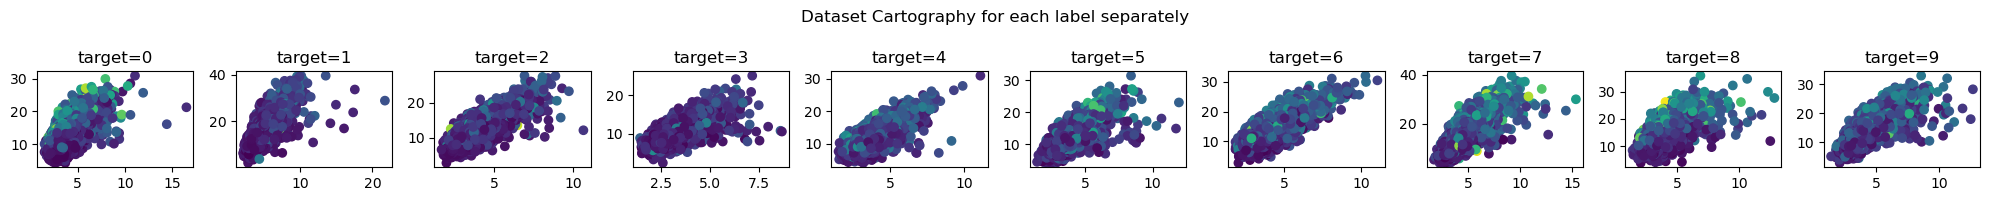

In [67]:
targ = train_dataset.targets
unique = np.unique(targ)
fig, ax = plt.subplots(1, len(unique), figsize=[2*len(unique), 2])
fig.suptitle("Dataset Cartography for each label separately")
for i in unique:
    ax[i].set_title(f"target={i}")
    # ax[i].set_xlim([0,1])
    # ax[i].set_ylim([0,1])
    ax[i].scatter(x[targ == i], y[targ == i], c=msd_means[targ == i])
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

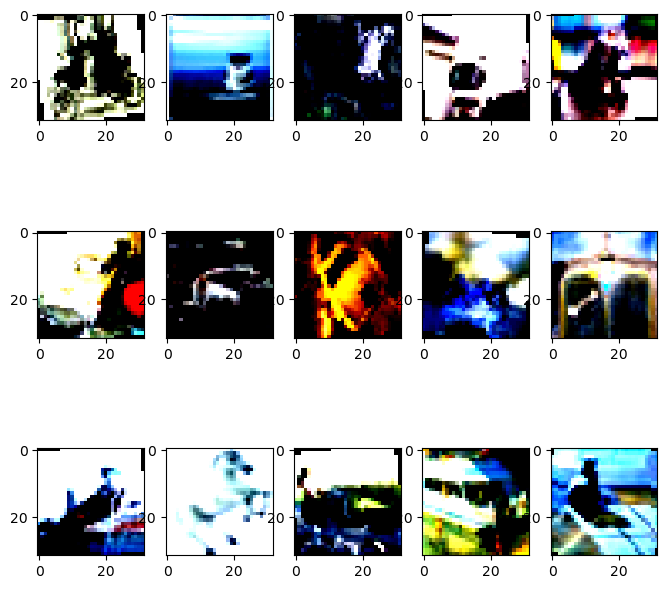

In [68]:
import numpy as np
import matplotlib.pyplot as plt

N=15
sorted_idx = np.argsort(y)
imgs = torch.cat([ds_train[idx][0].reshape(1, 3, 32, 32) for idx in sorted_idx[:N]])

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    img = np.rollaxis(imgs[i-1].numpy(), 0, 3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

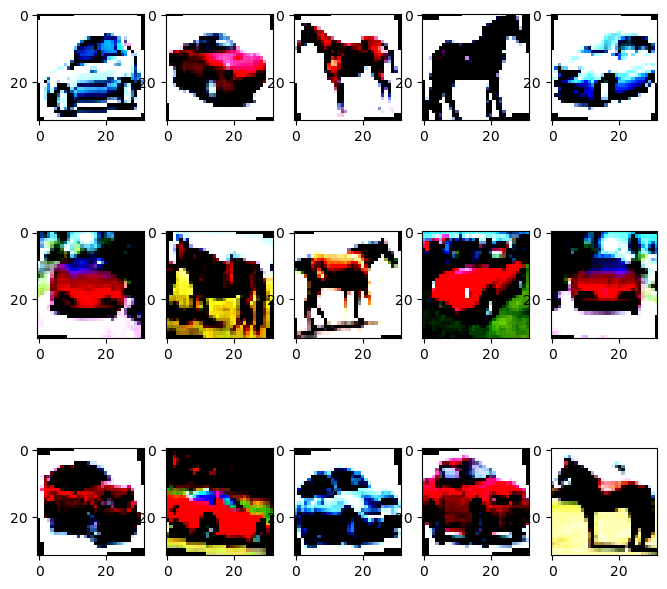

In [69]:
N=15
sorted_idx = np.argsort(y)
imgs = torch.cat([ds_train[idx][0].reshape(1, 3, 32, 32) for idx in sorted_idx[-N:]])

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 3
for i in range(1, columns*rows +1):
    img = np.rollaxis(imgs[i-1].numpy(), 0, 3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [70]:
sorted_idx[:N]

array([21538,  4847, 26135,  3597, 23597, 33859, 41578, 49447, 18046,
       36218, 40622, 24237, 22896,  5641, 46308], dtype=int64)

### Show the SSFT metric

(array([2.6187e+04, 1.6590e+04, 4.5260e+03, 1.5520e+03, 6.2000e+02,
        2.6700e+02, 1.5200e+02, 7.1000e+01, 2.7000e+01, 8.0000e+00]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

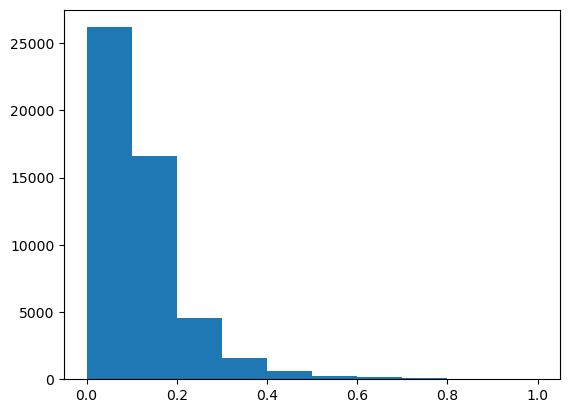

In [71]:
plt.hist(msd_means)

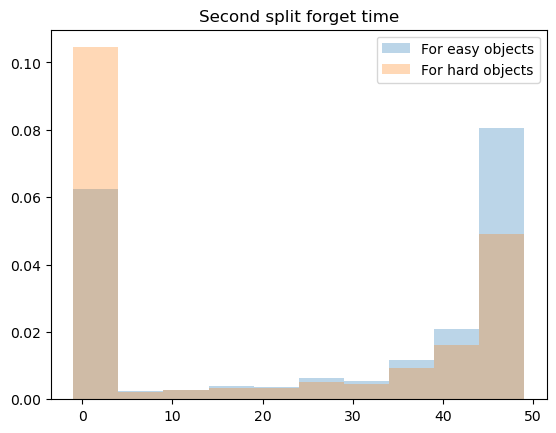

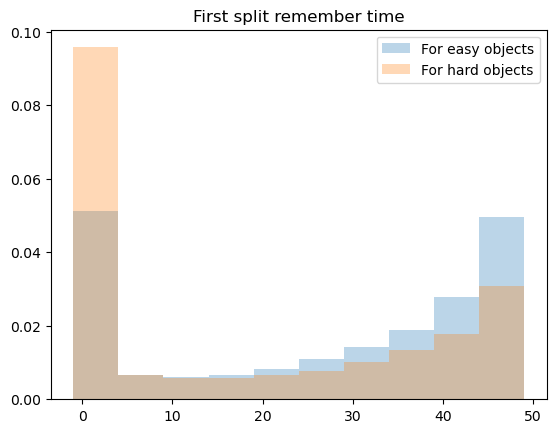

In [76]:
easy_idxs = msd_means <= 0.15

plt.title("Second split forget time")
plt.hist(ssft[easy_idxs], alpha=0.3, label="For easy objects", density=True)
plt.hist(ssft[~easy_idxs], alpha=0.3, label="For hard objects", density=True)
plt.legend()
plt.show()

plt.title("First split remember time")
plt.hist(fsrt[easy_idxs], alpha=0.3, label="For easy objects", density=True)
plt.hist(fsrt[~easy_idxs], alpha=0.3, label="For hard objects", density=True)
plt.legend()
plt.show()

## Sergey's paper metric
I probably should have asked which paper...

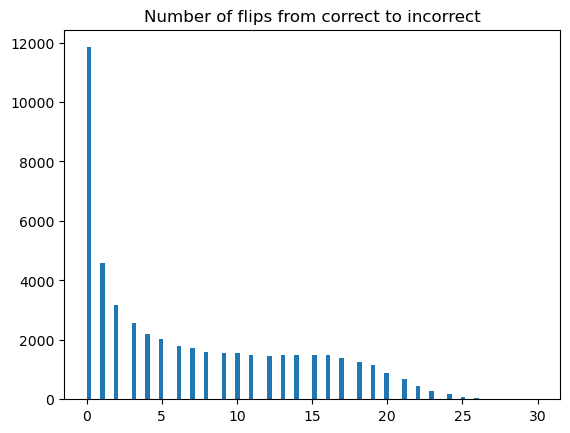

In [73]:
plt.title("Number of flips from correct to incorrect")
plt.hist(changes, bins=100)
plt.show()